In [156]:
from resize_and_padding import resize_and_pad_image

Total Contours Found: 450
Contours After Removing Duplicates: 161


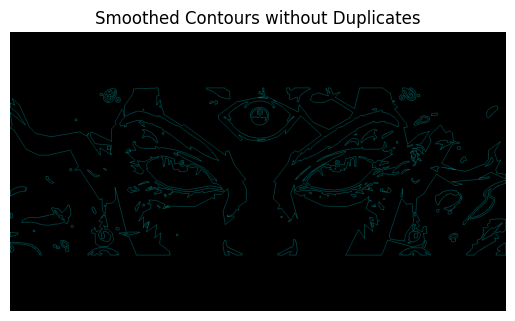

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("images/random.jpeg")
img = resize_and_pad_image(img, (1920, 1080))
# Make a mask
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = cv2.inRange(gray, 50, 100)

# Apply Gaussian blur to smooth the mask before finding contours
mask = cv2.GaussianBlur(mask, (5, 5), 0)

# Get contours (for OpenCV 4.x, no need to unpack contours as third argument)
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Total Contours Found:", len(contours))

# Remove contours with very similar perimeters
cutoff_percent = 0.003
no_dupes = []
for con in contours:
    perim = cv2.arcLength(con, closed=True)
    # Check for duplicates
    dupe_flag = False
    for dupe in no_dupes:
        dupe_perim = cv2.arcLength(dupe, closed=True)
        if abs(dupe_perim - perim) < cutoff_percent * perim:
            dupe_flag = True
            break

    # Add to the list if not a duplicate
    if not dupe_flag:
        no_dupes.append(con)

print("Contours After Removing Duplicates:", len(no_dupes))

# Approximate each contour to smooth it using the Douglas-Peucker algorithm
smoothed_contours = []
epsilon_factor = 0.001 # Control the amount of smoothing (higher means more smoothing)

for con in no_dupes:
    epsilon = epsilon_factor * cv2.arcLength(con, True)
    approx = cv2.approxPolyDP(con, epsilon, True)
    smoothed_contours.append(approx)

# Create a blank canvas for drawing
blank = np.zeros_like(img)

# Draw each smoothed contour sequentially on the blank canvas
for idx, con in enumerate(smoothed_contours):
    cv2.drawContours(blank, [con], -1, (200, 200, 0), 1)

# Display the result using matplotlib
plt.imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for proper display
plt.title('Smoothed Contours without Duplicates')
plt.axis('off')
plt.show()

# Save the result
# cv2.imwrite("smoothed_contours.png", blank)


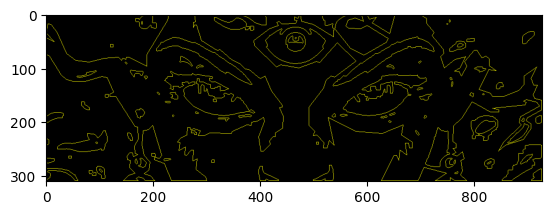

In [155]:
plt.imshow(blank)

100%|██████████| 161/161 [00:43<00:00,  3.68it/s]


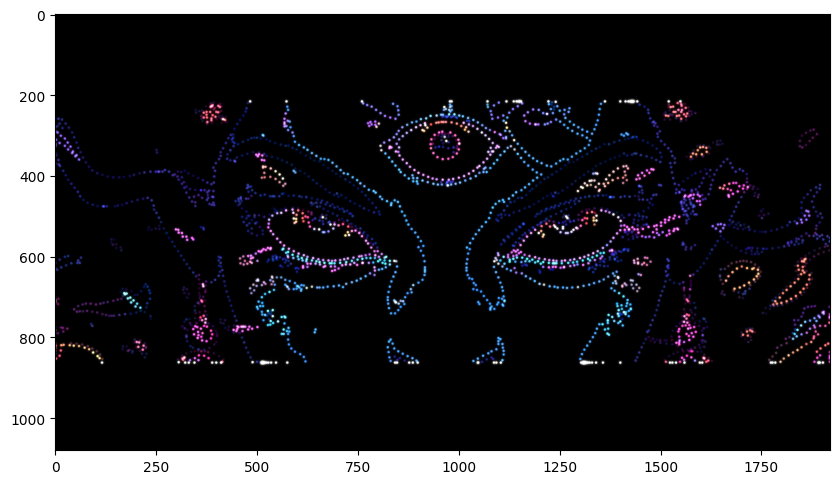

Image saved as output_image_glow_sampled_colors.png


In [170]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

def project_coordinates(original_shape, new_shape, old_coordinates):
    # Unpack dimensions
    original_height, original_width = original_shape[:2]
    new_height, new_width = new_shape

    # Unpack old coordinates
    x, y = old_coordinates

    # Calculate the scale factors for x and y dimensions
    scale_x = new_width / original_width
    scale_y = new_height / original_height

    # Project old coordinates to new coordinates
    new_x = int(x * scale_x)
    new_y = int(y * scale_y)

    return new_x, new_y


def sample_contour_points_by_distance(contour, distance_between_points):
    contour = contour.astype(np.float32)
    if len(contour) == 0:
        return np.array([])

    contour_length = cv2.arcLength(contour, True)
    sampled_points = []
    distance_accumulator = 0
    current_point = contour[0][0]

    sampled_points.append(current_point)

    for i in range(1, len(contour)):
        pt1 = current_point
        pt2 = contour[i][0]

        segment_length = np.linalg.norm(pt2 - pt1)

        while distance_accumulator + segment_length >= distance_between_points:
            ratio = (distance_between_points - distance_accumulator) / segment_length
            interpolated_point = pt1 + ratio * (pt2 - pt1)
            sampled_points.append(interpolated_point)
            current_point = interpolated_point
            distance_accumulator = 0
            segment_length -= distance_between_points - distance_accumulator

        distance_accumulator += segment_length
        current_point = pt2

    return np.array(sampled_points)

def draw_glowing_circle(image, center, color, radius=3, intensity=255, decay = 2):
    glow_layers = 3

    for i in range(glow_layers):
        if i == 0:
            glow_layer = np.zeros_like(image)
            b, g, r = map(int, color)
            cv2.circle(glow_layer, center, radius, (b, g, r), -1)
            image = cv2.addWeighted(image, 1.0, glow_layer, 1.0, 0)
        else:
            alpha = max(int(intensity / (decay ** i)), 5)
            blur_radius = (i + 1) * 6
            if blur_radius % 2 == 0:
                blur_radius += 1
            glow_layer = np.zeros_like(image)
            b, g, r = map(int, color)
            cv2.circle(glow_layer, center, radius, (b, g, r), -1)
            glow_layer = cv2.GaussianBlur(glow_layer, (blur_radius, blur_radius), 0)
            image = cv2.addWeighted(image, 1.0, glow_layer, alpha / 255.0, 0)

    return image

# Adjust contours and sample points
scaled_contours = [con for con in no_dupes]
distance_between_spheres = 8

img_height, img_width = img.shape[:2]
blank = np.zeros((img_height, img_width, 3), dtype=np.uint8)
blank_hd = np.zeros((1080, 1920, 3), dtype=np.uint8)

# Draw sampled points with glow effect
for idx, con in tqdm(enumerate(scaled_contours), total=len(scaled_contours)):
    con = con.astype(np.int32)
    if len(con) == 0:
        continue

    sampled_points = sample_contour_points_by_distance(con, distance_between_spheres)
    
    if len(sampled_points) == 0:
        continue

    for point in sampled_points:
        x, y = point.astype(int)
        
        # Ensure the new coordinates are still within the bounds of the new canvas
        if x >= blank_hd.shape[1] or y >= blank_hd.shape[0] or x < 0 or y < 0:
            continue
        
        color = img[y, x]  # Get color from the original image
        
        # Draw the glowing circle on the high-definition canvas
        blank_hd = draw_glowing_circle(blank_hd, (x, y), color)

blank_rgb = cv2.cvtColor(blank_hd, cv2.COLOR_BGR2RGB)

# Save the final output image
output_path = "output_image_glow_sampled_colors.png"
cv2.imwrite(output_path, cv2.cvtColor(blank_rgb, cv2.COLOR_RGB2BGR))

# Optionally display the image
plt.figure(figsize=(10, 10))
plt.imshow(blank_rgb)
plt.show()

print(f"Image saved as {output_path}")


In [147]:
img.shape

(311, 927, 3)

In [148]:
sampled_points[0]

array([178.,  14.], dtype=float32)